In [37]:
import numpy as np 
import pandas as pd 

import math 
from datetime import date, timedelta, datetime 
import time
import os

from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns

import sklearn
from sklearn.preprocessing import  MinMaxScaler 

from sklearn.metrics import mean_absolute_error, mean_squared_error 

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import backend

from tensorflow.keras.models import load_model
import joblib

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters


from google.cloud import bigquery
from google.oauth2 import service_account

  
print('Tensorflow Version: ' + tf.__version__)
print('Bigquery Version: ' + bigquery.__version__)
print('Pandas Version: ' + pd.__version__)
print('Scikit-Learn Version: ' + sklearn.__version__)
print('Keras Tuner: '+ kt.__version__)



Tensorflow Version: 2.12.0
Bigquery Version: 3.11.4
Pandas Version: 1.5.3
Scikit-Learn Version: 1.2.1
Keras Tuner: 1.3.5


In [38]:
# Load the TensorBoard notebook extension.
#%load_ext tensorboard
#%reload_ext tensorboard

# Reference Document

* [https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/](https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/)
* [https://www.relataly.com/univariate-stock-market-forecasting-using-a-recurrent-neural-network/122/](https://www.relataly.com/univariate-stock-market-forecasting-using-a-recurrent-neural-network/122/)
* [https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/](https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/)
* [https://www.relataly.com/regression-error-metrics-python/923/](https://www.relataly.com/regression-error-metrics-python/923/)
* [https://keras.io/guides/keras_tuner/getting_started/](https://keras.io/guides/keras_tuner/getting_started/)
* [https://www.tensorflow.org/tutorials/keras/keras_tuner] (https://www.tensorflow.org/tutorials/keras/keras_tuner)
* [https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
* [http://colah.github.io/posts/2015-08-Understanding-LSTMs/](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Determining the Right Batch Size for a Neural Network to Get Better and Faster Results](https://medium.com/data-science-365/determining-the-right-batch-size-for-a-neural-network-to-get-better-and-faster-results-7a8662830f15#:~:text=Default%20value%20%3D%2032&text=This%20is%20because%20the%20batch,%2C%20256%2C%20512%20and%201024!)

# My Ref
* https://github.com/technqvi/SMart-AI/blob/main/Model-TF_Keras/DNN-1-TF-KerasProcessing/multi_train_dnn1_incident.ipynb
* https://github.com/technqvi/SMart-AI/blob/main/Model-TF_Keras/DNN-1-TF-KerasProcessing/multi_tuned_dnn1_incident.ipynb

* https://keras.io/guides/keras_tuner/getting_started/
* https://www.tensorflow.org/tutorials/keras/keras_tuner  by Hyperband tuner
* https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f


In [39]:
start_date='2015-01-01'
end_date='2024-03-31'

# start_date='2023-01-01'
# end_date='2023-11-15'

asset_name='SPY'   

# univaiate  (single feature)
prediction_col='EMA1'
feature_cols=['EMA1']

# multpvaric (nultiple features)
# prediction_col='Close'
# feature_cols=[prediction_col,'EMA1','EMA2','MACD','SIGNAL']

strStartMY=datetime.strptime(start_date,"%Y-%m-%d").strftime("%m%y")
strEndMY=datetime.strptime(end_date,"%Y-%m-%d").strftime("%m%y")
period_str=f"M{strStartMY}-{strEndMY}"
data_path=f"train_data/{asset_name}_{period_str}.csv"
print(data_path)

tsb_path="tsb_logs/tune/"

train_data/SPY_M0115-0324.csv


# Load the Data from  BigQuery To Create TrainData as CSV File 

In [40]:
projectId="pongthorn"
dataset_id='FinAssetForecast'
table_data_id=f"{projectId}.{dataset_id}.fin_data"
print(table_data_id)

client = bigquery.Client(project=projectId )

def load_data_bq(sql:str):
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 return df



if  os.path.exists(data_path)==False:
    sqlData=f"""
     select * from  `{table_data_id}` where Symbol='{asset_name}' and (Date>='{start_date}' and Date<='{end_date}')
    """
    print(sqlData)
    df=load_data_bq(sqlData)
    df=df.sort_values(by="Date")
    df=df.drop_duplicates(subset=['Date','Symbol'],keep='last')
    df=df.drop(columns=['ImportDateTime'])
    df.to_csv(data_path,index=False)
    print(df.info())
    print("Load Data from BigQuery and Save it as csv.")
else:
    print(f"Load csv {data_path}")

pongthorn.FinAssetForecast.fin_data
Load csv train_data/SPY_M0115-0324.csv


# Init ML Constant Variable

In [41]:
date_col='Date'

main_obj_metric='mean_absolute_error'
main_loss='mean_absolute_error'


input_sequence_length=60 #60  #60 #120
output_sequence_length =10  #10  # 10 #20
train_ratio=0.8

n_epochs =200  #250  #50 #100/150/200/250/300
n_batch_size = 32  # 16/32/64
n_early=21
# n_early=int(n_epochs/10) #21

seed=99

#Tuning

neuron_number=0 # 
#if >0 , we recommend  initializing 32,64,128 but it should be more that input_sequence_length * no_feature (60x1) 
# else 0, we use  input_sequence_length * no_feature (60x1)

opitmizer_algo="bayesian"  # bayesian=1 or hypterband=2

# number of unit node in hidden laryer
mx_step=4 # 6# 2,3,5,10
mxMultipleStep=1  # double trail
nExecutions_per_trial=3  #5 #3  #averger re-run on 1 trail 

# dropout rate
min_drop=0.0
max_drop=0.2  #0.2 #0.1 0.2  0.5
step_drop=0.1

# learingRatelist= [0.1,0.01,0.001,0.0001]
#learingRatelist= [0.1,0.01,0.001]
learingRatelist= []
# min_rl=1e-3 #1e-4
# max_rl=1e-2
# no_rl=2

defaultMaxTrail=10

ratio_traial_max=1 #0.5 0.7/0.8/1

model_path='train_model'

tune_folder=f'{prediction_col}_{input_sequence_length}To{output_sequence_length}_{asset_name}_E{n_epochs}S{n_early}B{n_batch_size}'



modelName=f"{tune_folder}-{period_str}"

print(modelName)
print(tune_folder)


EMA1_60To10_SPY_E200S21B32-M0115-0324
EMA1_60To10_SPY_E200S21B32


# Read Train Data

In [42]:
df=pd.read_csv(data_path)
df.drop(columns=['Symbol'],inplace=True)

print(df.tail(input_sequence_length+output_sequence_length+2).reset_index(drop=True)[feature_cols])

df.set_index(date_col,inplace=True)
df=df[feature_cols]
print(df.info())

allCols=list(df.columns)
print(allCols)



        EMA1
0   462.7393
1   463.9419
2   465.4344
3   467.1470
4   467.3493
..       ...
67  516.6594
68  517.2365
69  517.5222
70  518.5491
71  519.3711

[72 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 2324 entries, 2015-01-02 to 2024-03-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    2324 non-null   float64
dtypes: float64(1)
memory usage: 36.3+ KB
None
['EMA1']


# Exploring the Data

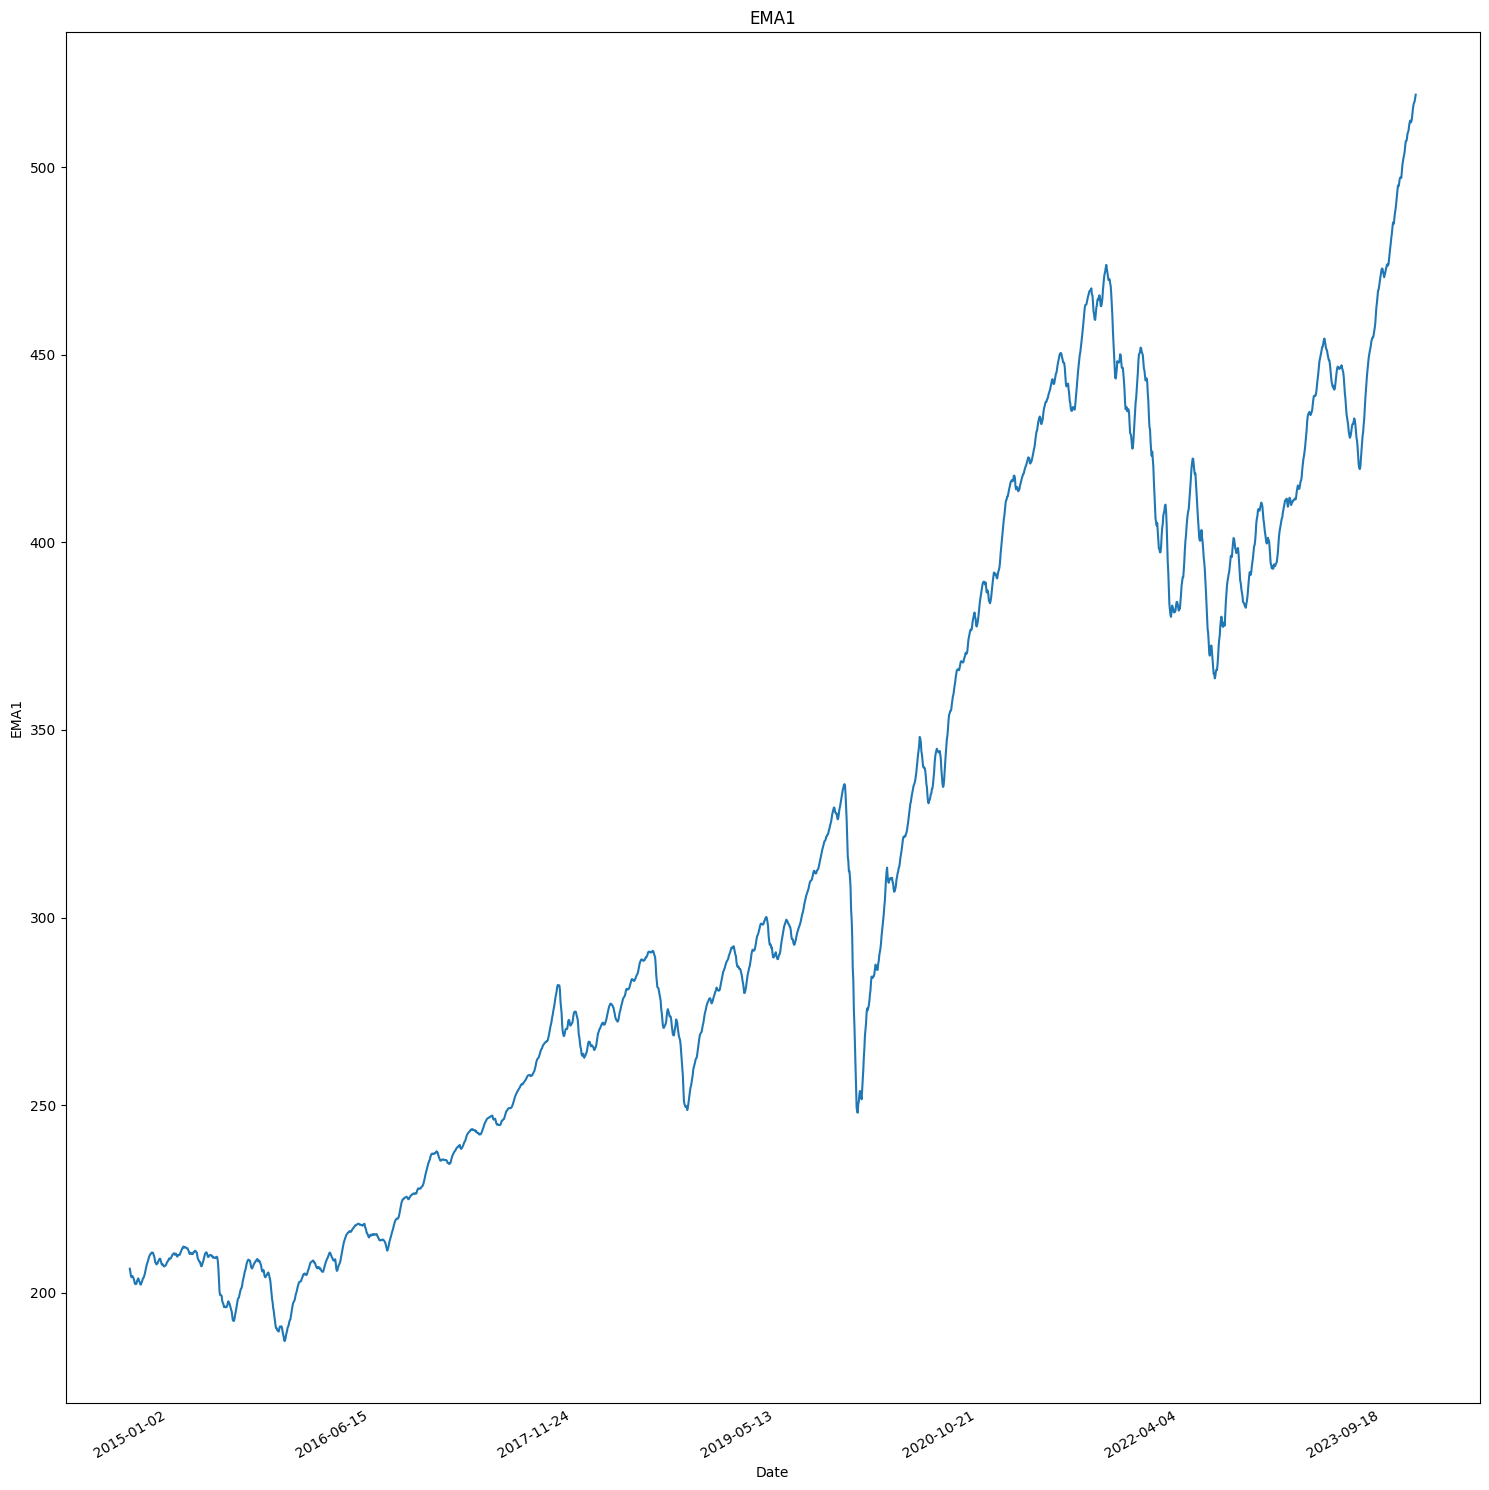

In [43]:
ncols = 1
nrows = len(feature_cols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df.columns[i])
fig.tight_layout()
plt.show()

In [44]:
# print("Split dataframe to show time-dependent data sequencial sample data point)")
# _dfTrain=df.loc['2015-01-01':'2021-12-31',:]
# print(_dfTrain.shape)  
# print(_dfTrain.head())
# print(_dfTrain.tail())

# print("=========================================================")

# _dfTest=df.loc['2022':,:]
# print(_dfTest.shape)  
# print(_dfTest.head())
# print(_dfTest.tail())

# Get Data Proper To Train Model

In [45]:
def prepare_data(df):

    print("Convert the data to numpy arrays value")
    np_feature_unscaled = np.array(df)
    np_feature_unscaled = np.reshape(np_feature_unscaled, (df.shape[0], -1))
    print(np_feature_unscaled.shape)
    
    np_pred_unscaled = np.array(df[prediction_col]).reshape(-1, 1)
    print(np_pred_unscaled.shape)
    
    return np_feature_unscaled, np_pred_unscaled

np_feature_unscaled, np_pred_unscaled = prepare_data(df)   


print("Feature Data",np_feature_unscaled.shape)
print(np_feature_unscaled[:3])
print("Prediction Data",np_pred_unscaled.shape)
print(np_pred_unscaled[:3])

Convert the data to numpy arrays value
(2324, 1)
(2324, 1)
Feature Data (2324, 1)
[[206.3589]
 [205.5155]
 [204.48  ]]
Prediction Data (2324, 1)
[[206.3589]
 [205.5155]
 [204.48  ]]


In [46]:
print(f"{input_sequence_length} = How far back the model looks back during training to forecast).")
print(f"{output_sequence_length} = How far into the future the model forecasts the target value")

#How much ratio to split
index_Prediction = df.columns.get_loc(prediction_col)
print(f"Prediction Index = {index_Prediction}")



60 = How far back the model looks back during training to forecast).
10 = How far into the future the model forecasts the target value
Prediction Index = 0


In [47]:
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_feature_unscaled.shape[0] * train_ratio)
print(f"{train_ratio} = {train_data_length} Split the training data into train and train data sets")

0.8 = 1860 Split the training data into train and train data sets


Target value column data disttribution


<AxesSubplot: ylabel='Frequency'>

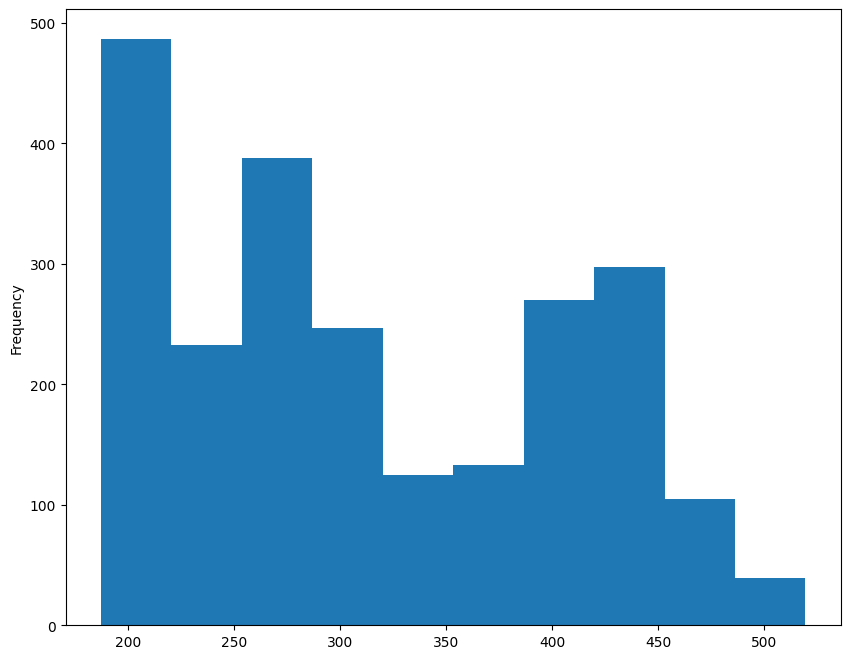

In [48]:
print("Target value column data disttribution")
df[prediction_col].plot.hist(figsize=(10, 8))


In [49]:
print("Scale feature and prediction to a range Max-Min between 0 and 1")
scaler_train = MinMaxScaler()
scaler_pred = MinMaxScaler()


print("Split data and apply only train to scale")

train_data = np_feature_unscaled[0:train_data_length, :]
test_data = np_feature_unscaled[train_data_length - input_sequence_length:, :]

np_PredictVal_unScaled=np_pred_unscaled[0:train_data_length]

print("Train Data to be scaled(feature and prediction)") 
print(train_data.shape,np_PredictVal_unScaled.shape)
print(train_data[:5])
print(np_PredictVal_unScaled[:5])

train_data=scaler_train.fit_transform(train_data)
test_data=scaler_train.transform(test_data)

print(f"For predict test that take the past {input_sequence_length} train value to predict the first test value")
np_scaled=scaler_train.transform(np_feature_unscaled)
np_scaled_prediction = scaler_pred.fit_transform(np_PredictVal_unScaled)

print("==============Scaler Object For Features=================")  
print(f"{scaler_train.n_features_in_} features are scaled in range 0-1 such as {feature_cols}")
print(f"Max:{scaler_train.data_max_} -  Min:{scaler_train.data_min_}")

print("==============Scaler Object For Prediction Target Value=================")  
print(f"{scaler_pred.n_features_in_} pred col is scaled in range 0-1 such as {prediction_col}")
print(f"Max:{scaler_pred.data_max_} -  Min:{scaler_pred.data_min_}")


print("=========================================")       
print("Scaled data completely")
print("Scaled train and test data")
print(train_data.shape,test_data.shape)
print(train_data[:5])
print(test_data[:5])

print("=========================================")  
print("Scale Prediction data (Scaled from Train data)")
print(np_scaled_prediction.shape)
print(np_scaled_prediction[:5])



Scale feature and prediction to a range Max-Min between 0 and 1
Split data and apply only train to scale
Train Data to be scaled(feature and prediction)
(1860, 1) (1860, 1)
[[206.3589]
 [205.5155]
 [204.48  ]
 [204.0854]
 [204.4153]]
[[206.3589]
 [205.5155]
 [204.48  ]
 [204.0854]
 [204.4153]]
For predict test that take the past 60 train value to predict the first test value
==============Scaler Object For Features=================
1 features are scaled in range 0-1 such as ['EMA1']
Max:[473.9935] -  Min:[187.0927]
==============Scaler Object For Prediction Target Value=================
1 pred col is scaled in range 0-1 such as EMA1
Max:[473.9935] -  Min:[187.0927]
Scaled data completely
Scaled train and test data
(1860, 1) (524, 1)
[[0.06715283]
 [0.06421314]
 [0.06060387]
 [0.05922849]
 [0.06037836]]
[[0.8672353 ]
 [0.86769608]
 [0.86385852]
 [0.86573164]
 [0.86588256]]
Scale Prediction data (Scaled from Train data)
(1860, 1)
[[0.06715283]
 [0.06421314]
 [0.06060387]
 [0.05922849]
 [

# Creating the Input data  as 3 dimension array (samples, time steps, features]

In [50]:
print("The LSTM RNN needs data with the format of [sample rows, time steps, features]")
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:])
        y.append(data[i:i + output_sequence_length, index_Prediction]) 
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

The LSTM RNN needs data with the format of [sample rows, time steps, features]


In [51]:
print(f"Here, we create {len(train_data)} samples, input_sequence_length time steps per sample, and features")

print("Generate training data and test data")
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

print("The shapes: the result is: (rows, training_sequence, features) (prediction value, )")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(f"Use {prediction_col} samples over the past {input_sequence_length} days to predict the future over the next {output_sequence_length} days")
print(x_train[-3:],y_train[-3:])

Here, we create 1860 samples, input_sequence_length time steps per sample, and features
Generate training data and test data
The shapes: the result is: (rows, training_sequence, features) (prediction value, )
(1790, 60, 1) (1790, 10)
(454, 60, 1) (454, 10)
Use EMA1 samples over the past 60 days to predict the future over the next 10 days
[[[0.90929199]
  [0.91117452]
  [0.91689776]
  [0.91637075]
  [0.91032475]
  [0.90446559]
  [0.90415851]
  [0.90422404]
  [0.89823207]
  [0.89153568]
  [0.88310385]
  [0.8713761 ]
  [0.86580484]
  [0.8672353 ]
  [0.86769608]
  [0.86385852]
  [0.86573164]
  [0.86588256]
  [0.86376267]
  [0.8539544 ]
  [0.84391434]
  [0.84277214]
  [0.84061425]
  [0.83542047]
  [0.82922564]
  [0.82996806]
  [0.83656442]
  [0.84541521]
  [0.85484321]
  [0.86247476]
  [0.87201395]
  [0.87614953]
  [0.88377307]
  [0.89140462]
  [0.89968902]
  [0.91004138]
  [0.9167057 ]
  [0.91768409]
  [0.91929545]
  [0.92307306]
  [0.92250701]
  [0.919186  ]
  [0.91789427]
  [0.91607726]


# Model Training

# Paramterter Network

In [52]:
# Configure the neural network model
# tf.random.set_seed(7)
print("Keras Tuning Parameter Setting")

model = Sequential()
n_output_neurons = output_sequence_length
  
inputshape_Timestamps= x_train.shape[1]
no_feature=x_train.shape[2]

if  neuron_number==0:
  
 neuron_number =inputshape_Timestamps * no_feature
 print(f"Initialize no.node from backward step x feature = {inputshape_Timestamps} x {no_feature} = {neuron_number}")     
else:
 print(f"Defined manually no.node ={neuron_number}")

step_neuron=int(neuron_number)
max_neuron=int(step_neuron*mx_step)
print(f"Train Row : {x_train.shape[0]}")
print(f"{inputshape_Timestamps}(backward step) x {no_feature}(features) = {neuron_number}, it is total no.NN  to predict future {n_output_neurons} with Hidden Node Unit from {step_neuron} to {max_neuron}")
    
neuron_list = [*range(neuron_number, max_neuron+step_neuron, step_neuron)]

drop_list=np.arange (min_drop, max_drop ,step_drop)
drop_list=np.append(drop_list,[max_drop])

if len(learingRatelist)>0:
    allPosComb=len(neuron_list)*len(drop_list)*len(learingRatelist)
    print(f"{neuron_list} and {drop_list} and {learingRatelist}")
    print(f"all combination : {len(neuron_list)} x {len(drop_list)} * {len(learingRatelist)} = {allPosComb}")
else:
    allPosComb=len(neuron_list)*len(drop_list)
    print(f"{neuron_list} and {drop_list}")
    print(f"all combination : {len(neuron_list)} x {len(drop_list)} = {allPosComb}")


nMax_trials=math.ceil(allPosComb*ratio_traial_max)
nMax_trials=nMax_trials*mxMultipleStep

if nMax_trials<defaultMaxTrail: 
    nMax_trials=defaultMaxTrail

nMax_trials=nMax_trials*1
print("MAx run :" ,nMax_trials , "each trail run to essemble ",nExecutions_per_trial)

Keras Tuning Parameter Setting
Initialize no.node from backward step x feature = 60 x 1 = 60
Train Row : 1790
60(backward step) x 1(features) = 60, it is total no.NN  to predict future 10 with Hidden Node Unit from 60 to 240
[60, 120, 180, 240] and [0.  0.1 0.2]
all combination : 4 x 3 = 12
MAx run : 12 each trail run to essemble  3


# NetWork Architeture Model Design

In [54]:
def build_singel_hidder_layer_model_way(hp):
    
    model = Sequential()

    model.add(LSTM( hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron) \
                   , return_sequences=False, input_shape=(inputshape_Timestamps,no_feature)))
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=min_drop,max_value=max_drop,step=step_drop))) 

    model.add(Dense(n_output_neurons))
    
    # hp_learning_rate = hp.Float("lr", min_value=min_rl, max_value=max_rl, sampling="log")
    if len(learingRatelist)>0:
        hp_learning_rate = hp.Choice('learning_rate', values=learingRatelist) 
        print(hp_learning_rate)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=main_loss, metrics=[main_obj_metric])
    else:
        print(hp_learning_rate)
        model.compile(optimizer="adam", loss=main_loss, metrics=[main_obj_metric])
    return model


def build_2hidden_layer_model_way(hp):
    
    model = Sequential()

    model.add(LSTM( hp.Int('input_unit_1',min_value=neuron_number ,max_value=max_neuron,step=step_neuron) \
                   , return_sequences=True, input_shape=(inputshape_Timestamps,no_feature)))
   
    model.add(Dropout(hp.Float('Dropout_rate',min_value=min_drop,max_value=max_drop,step=step_drop)))
    
    model.add(LSTM(hp.Int('hidden_layer_2',min_value=neuron_number,max_value=max_neuron,step=step_neuron) \
                  ,return_sequences=False ))
        
    model.add(Dropout(hp.Float('Dropout2_rate',min_value=min_drop,max_value=max_drop,step=step_drop)))

    model.add(Dense(n_output_neurons))
    
    if len(learingRatelist)>0:

        hp_learning_rate = hp.Choice('learning_rate', values=learingRatelist) 
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=main_loss, metrics=[main_obj_metric])
    else:
        model.compile(optimizer="adam", loss=main_loss, metrics=[main_obj_metric])
        

    return model

# Start Tuning 

In [55]:
buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"{buildtime}"
print(project_model)


t_Start=time.time()

print(f"Start tund at {datetime.now()}")

290324_1315
Start tund at 2024-03-29 13:15:06.142338


In [ ]:
# bayesian=1 or hypterband=2
print(opitmizer_algo)
if opitmizer_algo=="bayesian":
# https://keras.io/api/keras_tuner/tuners/bayesian/
    tuner = kt.BayesianOptimization(
            build_2hidden_layer_model_way,
            objective=main_obj_metric,
            max_trials=nMax_trials,
            seed=seed,
            executions_per_trial=nExecutions_per_trial,
            directory=f"tuning/{tune_folder}/",
            project_name= project_model
            )
else:
# https://keras.io/api/keras_tuner/tuners/hyperband/
    tuner = kt.Hyperband(
        build_2hidden_layer_model_way, objective=main_obj_metric,max_epochs=n_epochs,
        directory=f"tuning/{tune_folder}/",project_name= project_model)


early_stop = EarlyStopping(monitor='val_loss', patience=n_early, verbose=1)

log_dir = f"{tsb_path}" + datetime.now().strftime("%Y%m%d-%H%M")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

tuner.search(x_train, y_train, batch_size=n_batch_size, epochs=n_epochs,
                        validation_data=(x_test, y_test),
                        shuffle=False,verbose=1,callbacks=[early_stop,tensorboard_callback])



bayesian

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
120               |120               |input_unit_1
0                 |0                 |Dropout_rate
180               |180               |hidden_layer_2
0                 |0                 |Dropout2_rate

Epoch 1/200
56/56 [==============================] - 17s 151ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - val_loss: 0.0661 - val_mean_absolute_error: 0.0661
Epoch 2/200
47/56 [========================>.....] - ETA: 0s - loss: 0.0762 - mean_absolute_error: 0.0762

In [ ]:
print("Space to search")
tuner.search_space_summary()
print(f"Suumary of {nMax_trials}")
tuner.results_summary()

In [ ]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

# Load Tensorflow to look into train result more deeply

In [ ]:
# # # Load the TensorBoard notebook extension
# # # %tensorboard --logdir tsb_logs/tune/
# # load and comment to use notebook
# %tensorboard --logdir tsb_logs/tune/  --host 0.0.0.0
# from tensorboard import notebook
# notebook.list() # View open TensorBoard instances
# # Control TensorBoard display. If no port is provided, 
# # the most recently launched TensorBoard is used
# notebook.display(port=6006, height=1000)

# Get Optimal HyperParamters

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
print("build model from  the best tuning")

# model=tuner.get_best_models(num_models=1)[0]

model = tuner.hypermodel.build(best_hps)
print(model.summary())

# Training the TUNED Model 

In [ ]:
print(f"Training the Best Model with early stop at {n_early}")
t_Start=time.time()
print(datetime.now())


early_stop = EarlyStopping(monitor='val_loss', patience=n_early, verbose=1)
history = model.fit(x_train, y_train, 
                batch_size=n_batch_size, 
                epochs=n_epochs,
                shuffle=False,
                validation_data=(x_test, y_test),
                verbose=2, callbacks=[early_stop]
               )
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

In [ ]:
val_per_epoch = history.history[main_obj_metric]
best_epoch = len(val_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
print("List Metrics")
for key in history.history.keys():
    print(key)
print("=====================================================")    
# Evaluate the model on the test data using `evaluate`
#https://www.tensorflow.org/guide/keras/train_and_evaluate
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=n_batch_size)
print("test loss, test acc:", results)

In [ ]:
plt.title(main_obj_metric)
plt.plot(history.history[main_obj_metric], label='train')
plt.plot(history.history[f'val_{main_obj_metric}'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.title(f"Train/Test Loss - {main_loss}")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step #5 Evaluate Model Performance

In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
print(x_test.shape,y_pred_scaled.shape)

In [ ]:

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)

print(y_test_unscaled.shape)
print(y_test_unscaled[:5])
print(y_pred.shape)
print(y_pred[:5])

In [ ]:
dfTestActual=pd.DataFrame(data=y_test_unscaled, \
                          columns=[ f"Step{x}-{prediction_col}"  for x in range(1,output_sequence_length+1,1)])
dfTestPred=pd.DataFrame(data=y_pred, \
                          columns=[ f"Step{x}-Pred-{prediction_col}"  for x in range(1,output_sequence_length+1,1)]) 
dfActualPred=pd.concat([dfTestActual,dfTestPred],axis=1)
ActualPredcols=sorted(dfActualPred.columns.tolist())
dfActualPred=dfActualPred[ActualPredcols]
dfActualPred.head(3)

In [ ]:
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')
print("===========================================================================")

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')


# Root Mean  Squre Error
# RMSE = math.sqrt( mean_squared_error(y_test_unscaled, y_pred))
# print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')


# Plot Multiple Forcast (Most Complex Step)

In [ ]:
def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Prediction])\
    .rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = f"{asset_name}-{prediction_col}")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)



# Step #6 Create a new Forecast

In [ ]:
x_test_latest_batch = np_scaled[-(input_sequence_length+1):-1,:].reshape(1,input_sequence_length,len(feature_cols))
print(f"{x_test_latest_batch.shape} is the latest input batch from the test dataset, which is contains the price values for the last {input_sequence_length} trading days")

x_test_latest_batch

In [ ]:
y_pred_scaled = model.predict(x_test_latest_batch)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred_scaled)
print(f"Predict on the inverse transformed batch {y_pred_unscaled.shape}")
print(y_pred_unscaled)

In [ ]:
print("Prepare the data and plot the input data and the predictions")
x_test_unscaled_df, y_test_unscaled_df, _ = prepare_df(0, x_test_latest_batch, '', y_pred_unscaled)
print(f"X-Test= {x_test_unscaled_df.shape}")
print(f"Y-Test= {y_test_unscaled_df.shape}")

# print(x_test_unscaled_df.tail(len(y_test_unscaled_df)))
# print(y_test_unscaled_df.tail(len(y_test_unscaled_df)))

In [ ]:
plot_multi_test_forecast(x_test_unscaled_df, '',y_test_unscaled_df, "x_new Vs. y_new_pred")

#### 

# Create Final Model

In [46]:
dfAll=df.sort_values(by=[date_col]).copy()
npAll_unscaled, npPredictCol_unscaled = prepare_data(dfAll) 
print(npAll_unscaled.shape,npPredictCol_unscaled.shape)

Convert the data to numpy arrays value
(2281, 1)
(2281, 1)
(2281, 1) (2281, 1)


In [47]:
scalerFinalTrain = MinMaxScaler()
scalerFinalPred = MinMaxScaler()
npAll_scaled = scalerFinalTrain.fit_transform(npAll_unscaled)
npAllPredictCol_scaled = scalerFinalPred.fit_transform(npPredictCol_unscaled)
print(npAll_scaled.shape,npAllPredictCol_scaled.shape)
print(npAll_scaled[:2])
print(npAllPredictCol_scaled[:2])

(2281, 1) (2281, 1)
[[0.06523534]
 [0.06237959]]
[[0.06523534]
 [0.06237959]]


In [48]:
x_all, y_all = partition_dataset(input_sequence_length, output_sequence_length,npAll_scaled)
print(f"We will tranin {x_all.shape},{y_all.shape} with batch={n_batch_size} and best epoch={best_epoch}")

We will tranin (2216, 60, 1),(2216, 5) with batch=32 and best epoch=20


In [49]:
print(f"Training All")
t_Start=time.time()
print(datetime.now())

history_final=model.fit(x=x_all, y=y_all, batch_size=n_batch_size, epochs=best_epoch,shuffle=False)
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

Training All
2024-01-27 22:01:35.856060
Epoch 1/20
70/70 [==============================] - 15s 177ms/step - loss: 0.0219 - mean_absolute_error: 0.0219
Epoch 2/20
70/70 [==============================] - 11s 161ms/step - loss: 0.0365 - mean_absolute_error: 0.0365
Epoch 3/20
70/70 [==============================] - 10s 141ms/step - loss: 0.0495 - mean_absolute_error: 0.0495
Epoch 4/20
70/70 [==============================] - 10s 141ms/step - loss: 0.0195 - mean_absolute_error: 0.0195
Epoch 5/20
70/70 [==============================] - 10s 140ms/step - loss: 0.0260 - mean_absolute_error: 0.0260
Epoch 6/20
70/70 [==============================] - 10s 141ms/step - loss: 0.0178 - mean_absolute_error: 0.0178
Epoch 7/20
70/70 [==============================] - 10s 141ms/step - loss: 0.0222 - mean_absolute_error: 0.0222
Epoch 8/20
70/70 [==============================] - 10s 142ms/step - loss: 0.0236 - mean_absolute_error: 0.0236
Epoch 9/20
70/70 [==============================] - 10s 141ms/st

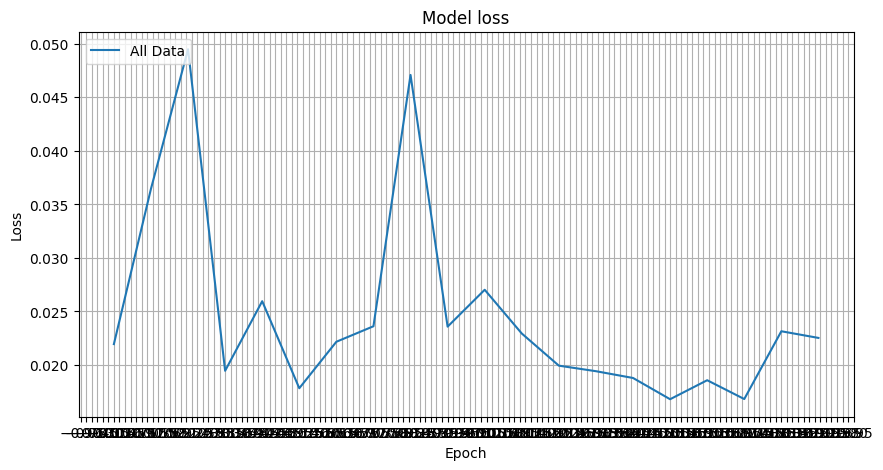

In [50]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history_final.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(n_epochs))
plt.legend(["All Data"], loc="upper left")
plt.grid()
plt.show()

In [51]:
print("Save model and scaler")

#modelName='test2022-20for10'
file_model=f'{model_path}/{modelName}_ma.h5'
file_scaler=f'{model_path}/scaler_{modelName}.gz'
file_scaler_pred=f'{model_path}/scaler_pred_{modelName}.gz'

model.save(file_model)

joblib.dump(scalerFinalTrain,file_scaler)
joblib.dump(scalerFinalPred ,file_scaler_pred)

Save model and scaler


['train_model/scaler_pred_EMA1_60To5_SPY_E150S15B32-M0115-0124.gz']